In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d kumaresanmanickavelu/lyft-udacity-challenge

100% 5.10G/5.11G [00:40<00:00, 193MB/s]
100% 5.11G/5.11G [00:40<00:00, 137MB/s]


In [2]:
import zipfile
zip_ref = zipfile.ZipFile('/content/lyft-udacity-challenge.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [3]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
import os
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import cv2

In [4]:
!pip install imageio
import imageio.v3 as iio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Text(0.5, 1.0, 'Segmentation')

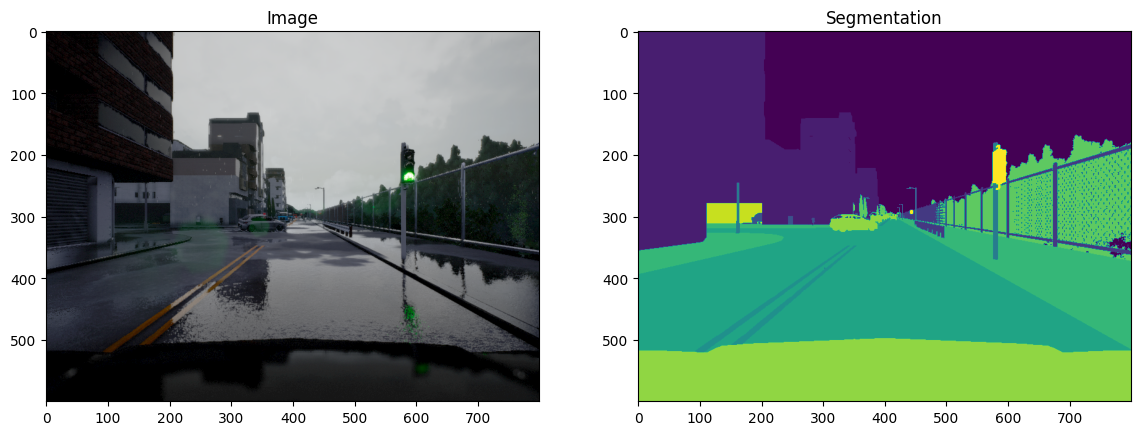

In [5]:
image_path = ('/content/dataA/dataA/CameraRGB/')
mask_path = ('/content/dataA/dataA/CameraSeg/')
test_path = ('/content/dataB/dataB/CameraRGB/')
test_mask = ('/content/dataB/dataB/CameraSeg/')
image_list = sorted(os.listdir(image_path))
mask_list = sorted(os.listdir(mask_path))
test_image_list = sorted(os.listdir(test_path))
test_mask_list = sorted(os.listdir(test_mask))
image_list = [image_path+i for i in image_list]
mask_list = [mask_path+i for i in mask_list]
test_image_list = [test_path+i for i in test_image_list]
test_mask_list = [test_mask+i for i in test_mask_list]
img =  iio.imread(image_list[12])
mask = iio.imread(mask_list[12])


fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask[:,:,0])
arr[1].set_title('Segmentation')

In [6]:
image_list_ds = tf.data.Dataset.list_files(image_list, shuffle=False)
mask_list_ds = tf.data.Dataset.list_files(mask_list, shuffle=False)
test_image_list_ds = tf.data.Dataset.list_files(test_image_list, shuffle=False)
test_mask_list_ds = tf.data.Dataset.list_files(test_mask_list, shuffle=False)


image_filenames = tf.constant(image_list)
masks_filenames = tf.constant(mask_list)
test_image_filenames = tf.constant(test_image_list)
test_masks_filenames = tf.constant(test_mask_list)
dataset = tf.data.Dataset.from_tensor_slices((image_filenames, masks_filenames))
test_dataset = tf.data.Dataset.from_tensor_slices((test_image_filenames, test_masks_filenames))

for image, mask in dataset.take(1):
    print(image)
    print(mask)

tf.Tensor(b'/content/dataA/dataA/CameraRGB/02_00_000.png', shape=(), dtype=string)
tf.Tensor(b'/content/dataA/dataA/CameraSeg/02_00_000.png', shape=(), dtype=string)


In [7]:
def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32) #/255

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True) #/255
    return img, mask

def preprocess(image, mask):
    input_image = tf.image.resize(image, (256, 256), method='nearest')
    input_mask = tf.image.resize(mask, (256, 256), method='nearest')

    return input_image, input_mask

image_ds = dataset.map(process_path)
test_image_ds = test_dataset.map(process_path)
processed_image_ds = image_ds.map(preprocess)
test_processed_image_ds = test_image_ds.map(preprocess)

In [8]:
IMG_HEIGHT=256
IMG_WIDTH=256
IMG_CHANNELS=3

In [9]:
from keras.models import Model
def unet_plus_plus(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
    inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs
    
    #00
    layer_0_0 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    
    layer_0_0 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(layer_0_0)
    
    p_1_0 = MaxPooling2D((2, 2))(layer_0_0)

    #10
    layer_1_0 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p_1_0)
    
    layer_1_0 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(layer_1_0)
    
    p_2_0 = MaxPooling2D((2, 2))(layer_1_0)

    #20
    layer_2_0 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p_2_0)
    
    layer_2_0 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(layer_2_0)
    
    p_3_0 = MaxPooling2D((2, 2))(layer_2_0)


    #30
    layer_3_0 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p_3_0)
    
    layer_3_0 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(layer_3_0)
    
    p_4_0 = MaxPooling2D(pool_size=(2, 2))(layer_3_0)

    #40
    layer_4_0 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p_4_0)
    
    layer_4_0 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(layer_4_0)
    
    #01
    conv_0_1 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(layer_1_0)
    conv_0_1= concatenate([conv_0_1,layer_0_0])
    layer_0_1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv_0_1)
    
    layer_0_1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(layer_0_1)
    
    # p_0_1 = MaxPooling2D((2, 2))(layer_0_1)

    #11
    conv_1_1 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(layer_2_0)
    conv_1_1= concatenate([conv_1_1,layer_1_0])
    layer_1_1 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv_1_1)
    
    layer_1_1 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(layer_1_1)
    
    # p_1_1 = MaxPooling2D((2, 2))(layer_1_1)

    #21
    conv_2_1 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(layer_3_0)
    conv_2_1= concatenate([conv_2_1,layer_2_0])
    layer_2_1 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv_2_1)
    
    layer_2_1 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(layer_2_1)
    
    # p_2_1 = MaxPooling2D((2, 2))(layer_2_1)

    #31
    conv_3_1 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(layer_4_0)
    conv_3_1= concatenate([conv_3_1,layer_3_0])
    layer_3_1 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv_3_1)
    
    layer_3_1 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(layer_3_1)
    
    # p_3_1 = MaxPooling2D((2, 2))(layer_3_1)

    #02
    conv_0_2 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(layer_1_1)
    conv_0_2= concatenate([conv_0_2,layer_0_0,layer_0_1])
    layer_0_2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv_0_2)
    
    layer_0_2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(layer_0_2)
    
    # p_0_2 = MaxPooling2D((2, 2))(layer_0_2)

    #12
    conv_1_2 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(layer_2_1)
    conv_1_2= concatenate([conv_1_2,layer_1_0,layer_1_1])
    layer_1_2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv_1_2)
    
    layer_1_2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(layer_1_2)
    
    # p_1_2 = MaxPooling2D((2, 2))(layer_1_2)

    #22
    conv_2_2 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(layer_3_1)
    conv_2_2= concatenate([conv_2_2,layer_2_0,layer_2_1])
    layer_2_2 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv_2_2)
    
    layer_2_2 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(layer_2_2)
    
    # p_2_2 = MaxPooling2D((2, 2))(layer_2_2)

    #03
    conv_0_3 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(layer_1_2)
    conv_0_3= concatenate([conv_0_3,layer_0_0,layer_0_1,layer_0_2])
    layer_0_3 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv_0_3)
    
    layer_0_3 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(layer_0_3)
    
    # p_0_3 = MaxPooling2D((2, 2))(layer_0_3)

    #13
    conv_1_3 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(layer_2_2)
    conv_1_3= concatenate([conv_1_3,layer_1_0,layer_1_1,layer_1_2])
    layer_1_3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv_1_3)
    
    layer_1_3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(layer_1_3)
    
    # p_1_3 = MaxPooling2D((2, 2))(layer_1_3)

    #03
    conv_0_4 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(layer_1_3)
    conv_0_4= concatenate([conv_0_4,layer_0_0,layer_0_1,layer_0_2,layer_0_3])
    layer_0_4 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv_0_4)
    
    layer_0_4 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(layer_0_4)
    
    # p_0_4 = MaxPooling2D((2, 2))(layer_0_4)


    outputs = Conv2D(23, (1, 1), activation="softmax")(layer_0_4)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.summary()
    
    return model

In [10]:
unet_model = unet_plus_plus(IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

In [11]:
class UpdatedMeanIoU(tf.keras.metrics.MeanIoU):
  def __init__(self,
               y_true=None,
               y_pred=None,
               num_classes=None,
               name=None,
               dtype=None):
    super(UpdatedMeanIoU, self).__init__(num_classes = 23,name=name, dtype=dtype)

  def update_state(self, y_true, y_pred, sample_weight=None):
    y_pred = tf.math.argmax(y_pred, axis=-1)
    return super().update_state(y_true, y_pred, sample_weight)

In [12]:
unet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[UpdatedMeanIoU(),'accuracy'])

In [13]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i])) #try , cmap='Paired'
        plt.axis('off')
    plt.show()

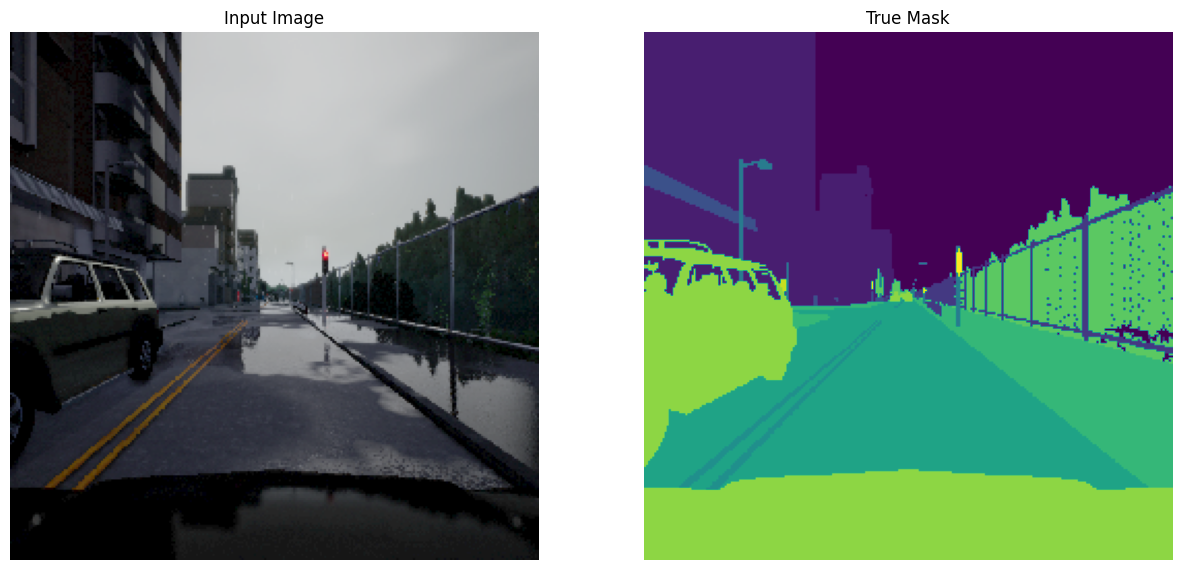

In [14]:
for image, mask in processed_image_ds.take(1):
    sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

In [15]:
EPOCHS = 50
VAL_SUBSPLITS = 10
BUFFER_SIZE = 500
BATCH_SIZE = 32
train_dataset = processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
tests_dataset = test_processed_image_ds.cache().batch(BATCH_SIZE)
print(processed_image_ds.element_spec)
model_history = unet_model.fit(train_dataset,validation_data=tests_dataset, epochs=EPOCHS)

(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(256, 256, 1), dtype=tf.uint8, name=None))
Epoch 1/50
32/32 [==============================] - 173s 3s/step - loss: 1.9252 - updated_mean_io_u: 0.0442 - accuracy: 0.3996 - val_loss: 1.4389 - val_updated_mean_io_u: 0.0912 - val_accuracy: 0.5009
Epoch 2/50
32/32 [==============================] - 62s 2s/step - loss: 1.1413 - updated_mean_io_u: 0.1520 - accuracy: 0.6232 - val_loss: 1.2496 - val_updated_mean_io_u: 0.1595 - val_accuracy: 0.5890
Epoch 3/50
32/32 [==============================] - 61s 2s/step - loss: 0.7708 - updated_mean_io_u: 0.2554 - accuracy: 0.7604 - val_loss: 0.5857 - val_updated_mean_io_u: 0.3079 - val_accuracy: 0.8240
Epoch 4/50
32/32 [==============================] - 62s 2s/step - loss: 0.5369 - updated_mean_io_u: 0.3225 - accuracy: 0.8400 - val_loss: 0.4932 - val_updated_mean_io_u: 0.3582 - val_accuracy: 0.8565
Epoch 5/50
32/32 [==============================] - 62s 2s/step - loss: 0.46

In [16]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def show_predictions(dataset=None, num=1):
    """
    Displays the first image of each of the num batches
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = unet_model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(unet_model.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 0s 37ms/step


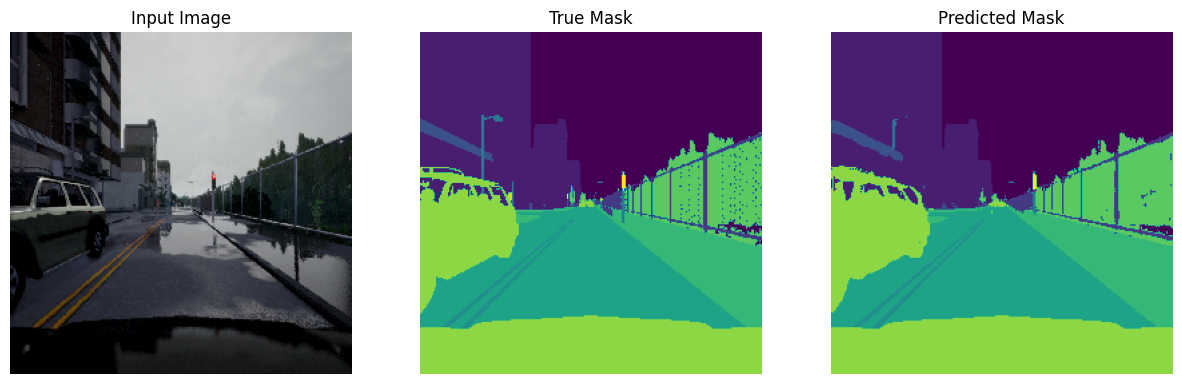

1/1 [==============================] - 0s 56ms/step


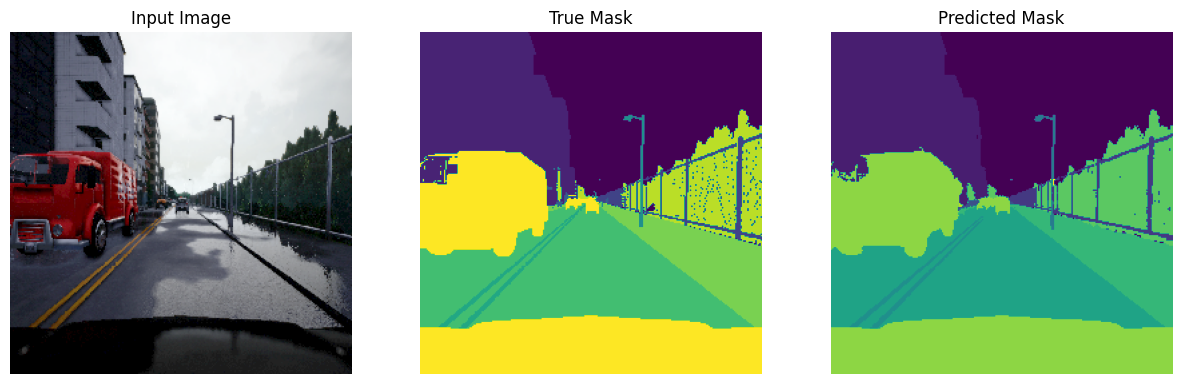

1/1 [==============================] - 0s 52ms/step


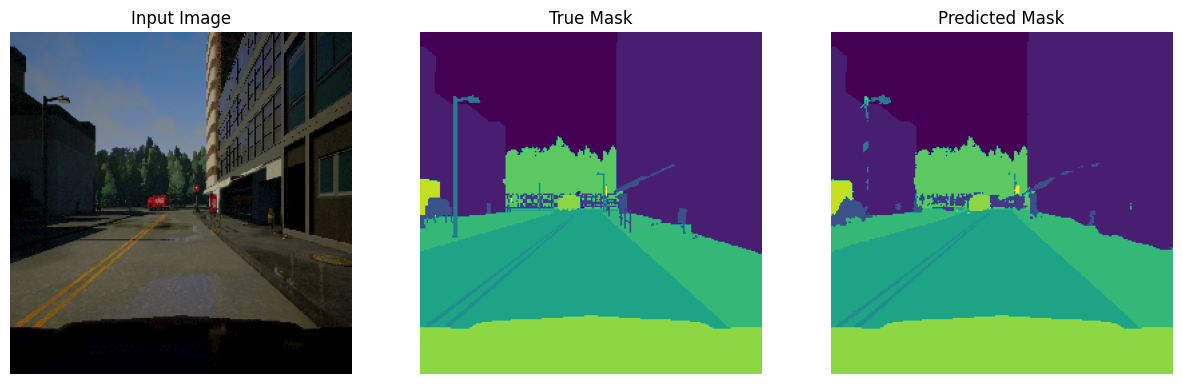

1/1 [==============================] - 0s 44ms/step


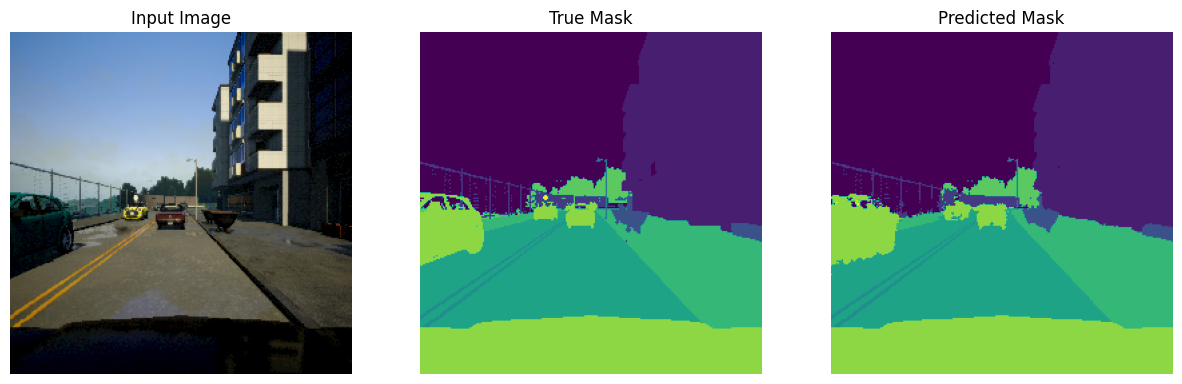

1/1 [==============================] - 0s 47ms/step


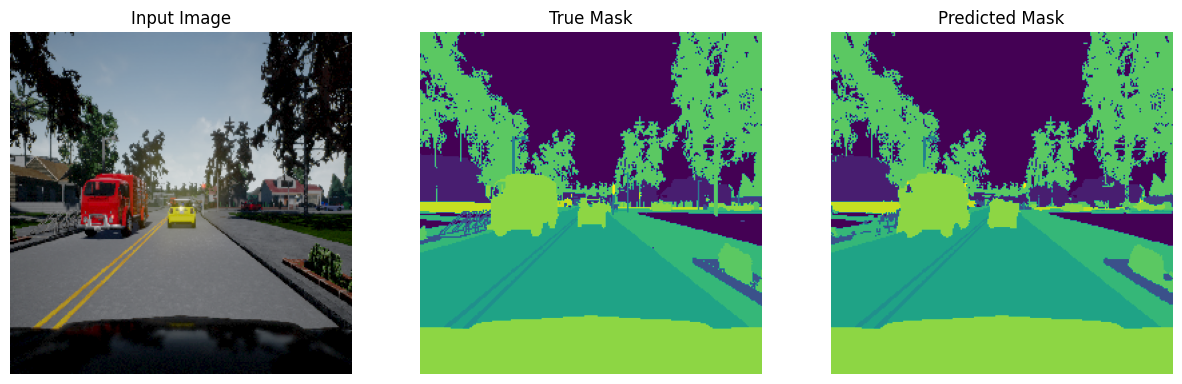

In [18]:
show_predictions(tests_dataset, 5)